In [1]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen

In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

### Import the metric -- scib

In [3]:
# !pip install --quiet scib
import scib

In [4]:
# !pip install --quiet louvain
import louvain

In [6]:
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/orig.ident' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/orig.ident' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/nCount_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/nFeature_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/sampleid' was written without encoding metadata.
  return func(*

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [7]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.3 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 30% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 30% known labels and 70% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_20014/3498436683.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['T_cells', 'T_cells', 'T_cells', 'ATII', 'Mac_alv', ..., 'B_Jchain+', 'Mac_alv', 'ATII', 'SMCs', 'B_cells']
Length: 6228
Categories (17, object): ['ATI', 'ATII', 'B_Jchain+', 'B_cells', ..., 'SMCs', 'Secretory', 'T_CD8+', 'T_cells']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_20014/3498436683.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [10]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('../R_lung_two_species/labels/hard_label_lung_two_species_70.csv', index=True)

In [11]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [12]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 273/273: 100%|█| 273/273 [4:56:23<00:00, 39.68s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|█| 273/273 [4:56:23<00:00, 65.14s/it, v_num=1, train_loss_st


In [17]:
# Load the pretrained models
adata = adata.copy()
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_loca

In [18]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

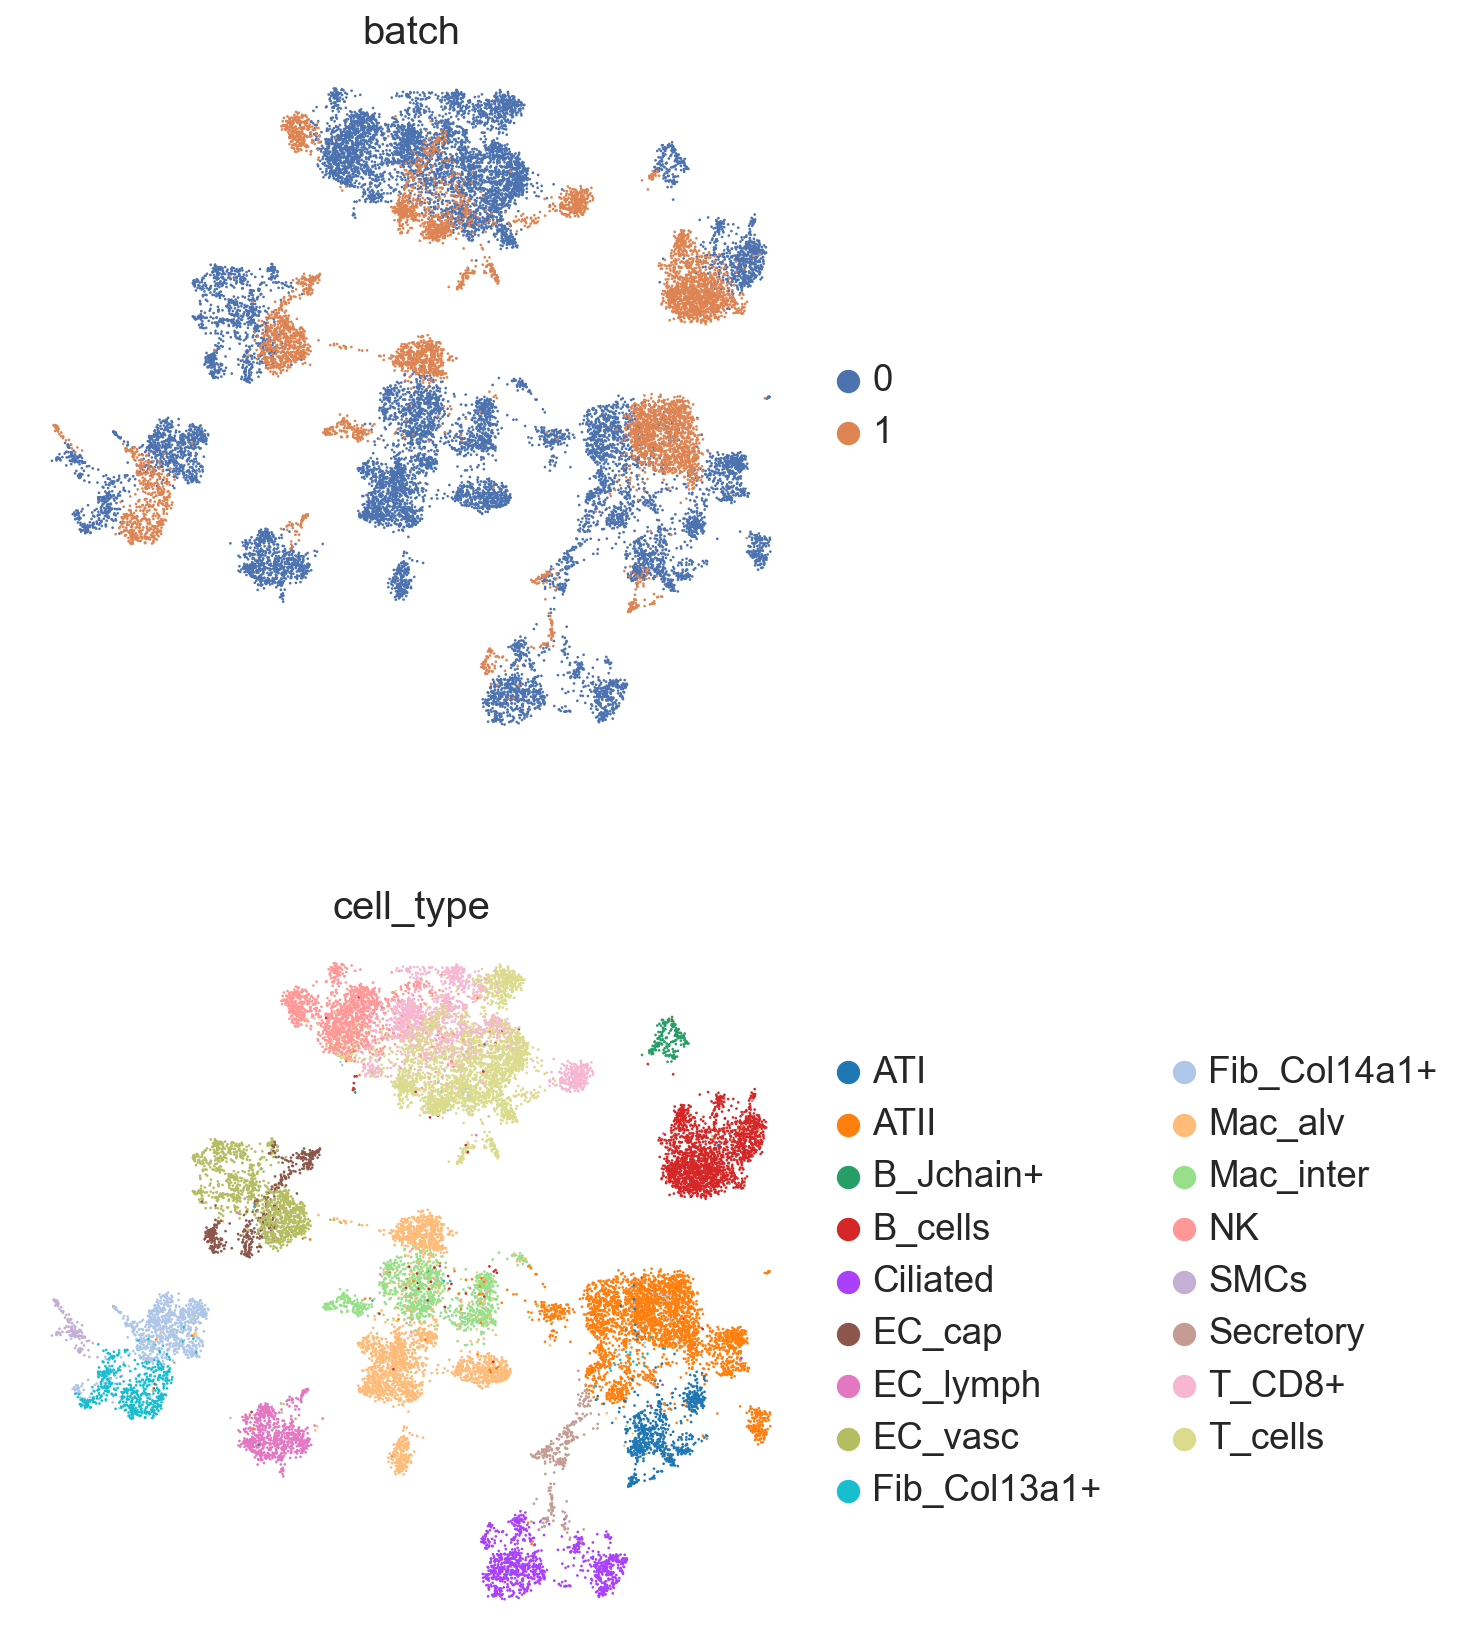

In [19]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

In [21]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [01:14<00:00,  3.70s/it, v_num=1, train_loss_step=463

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:14<00:00,  3.73s/it, v_num=1, train_loss_step=463


In [22]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [23]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [24]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

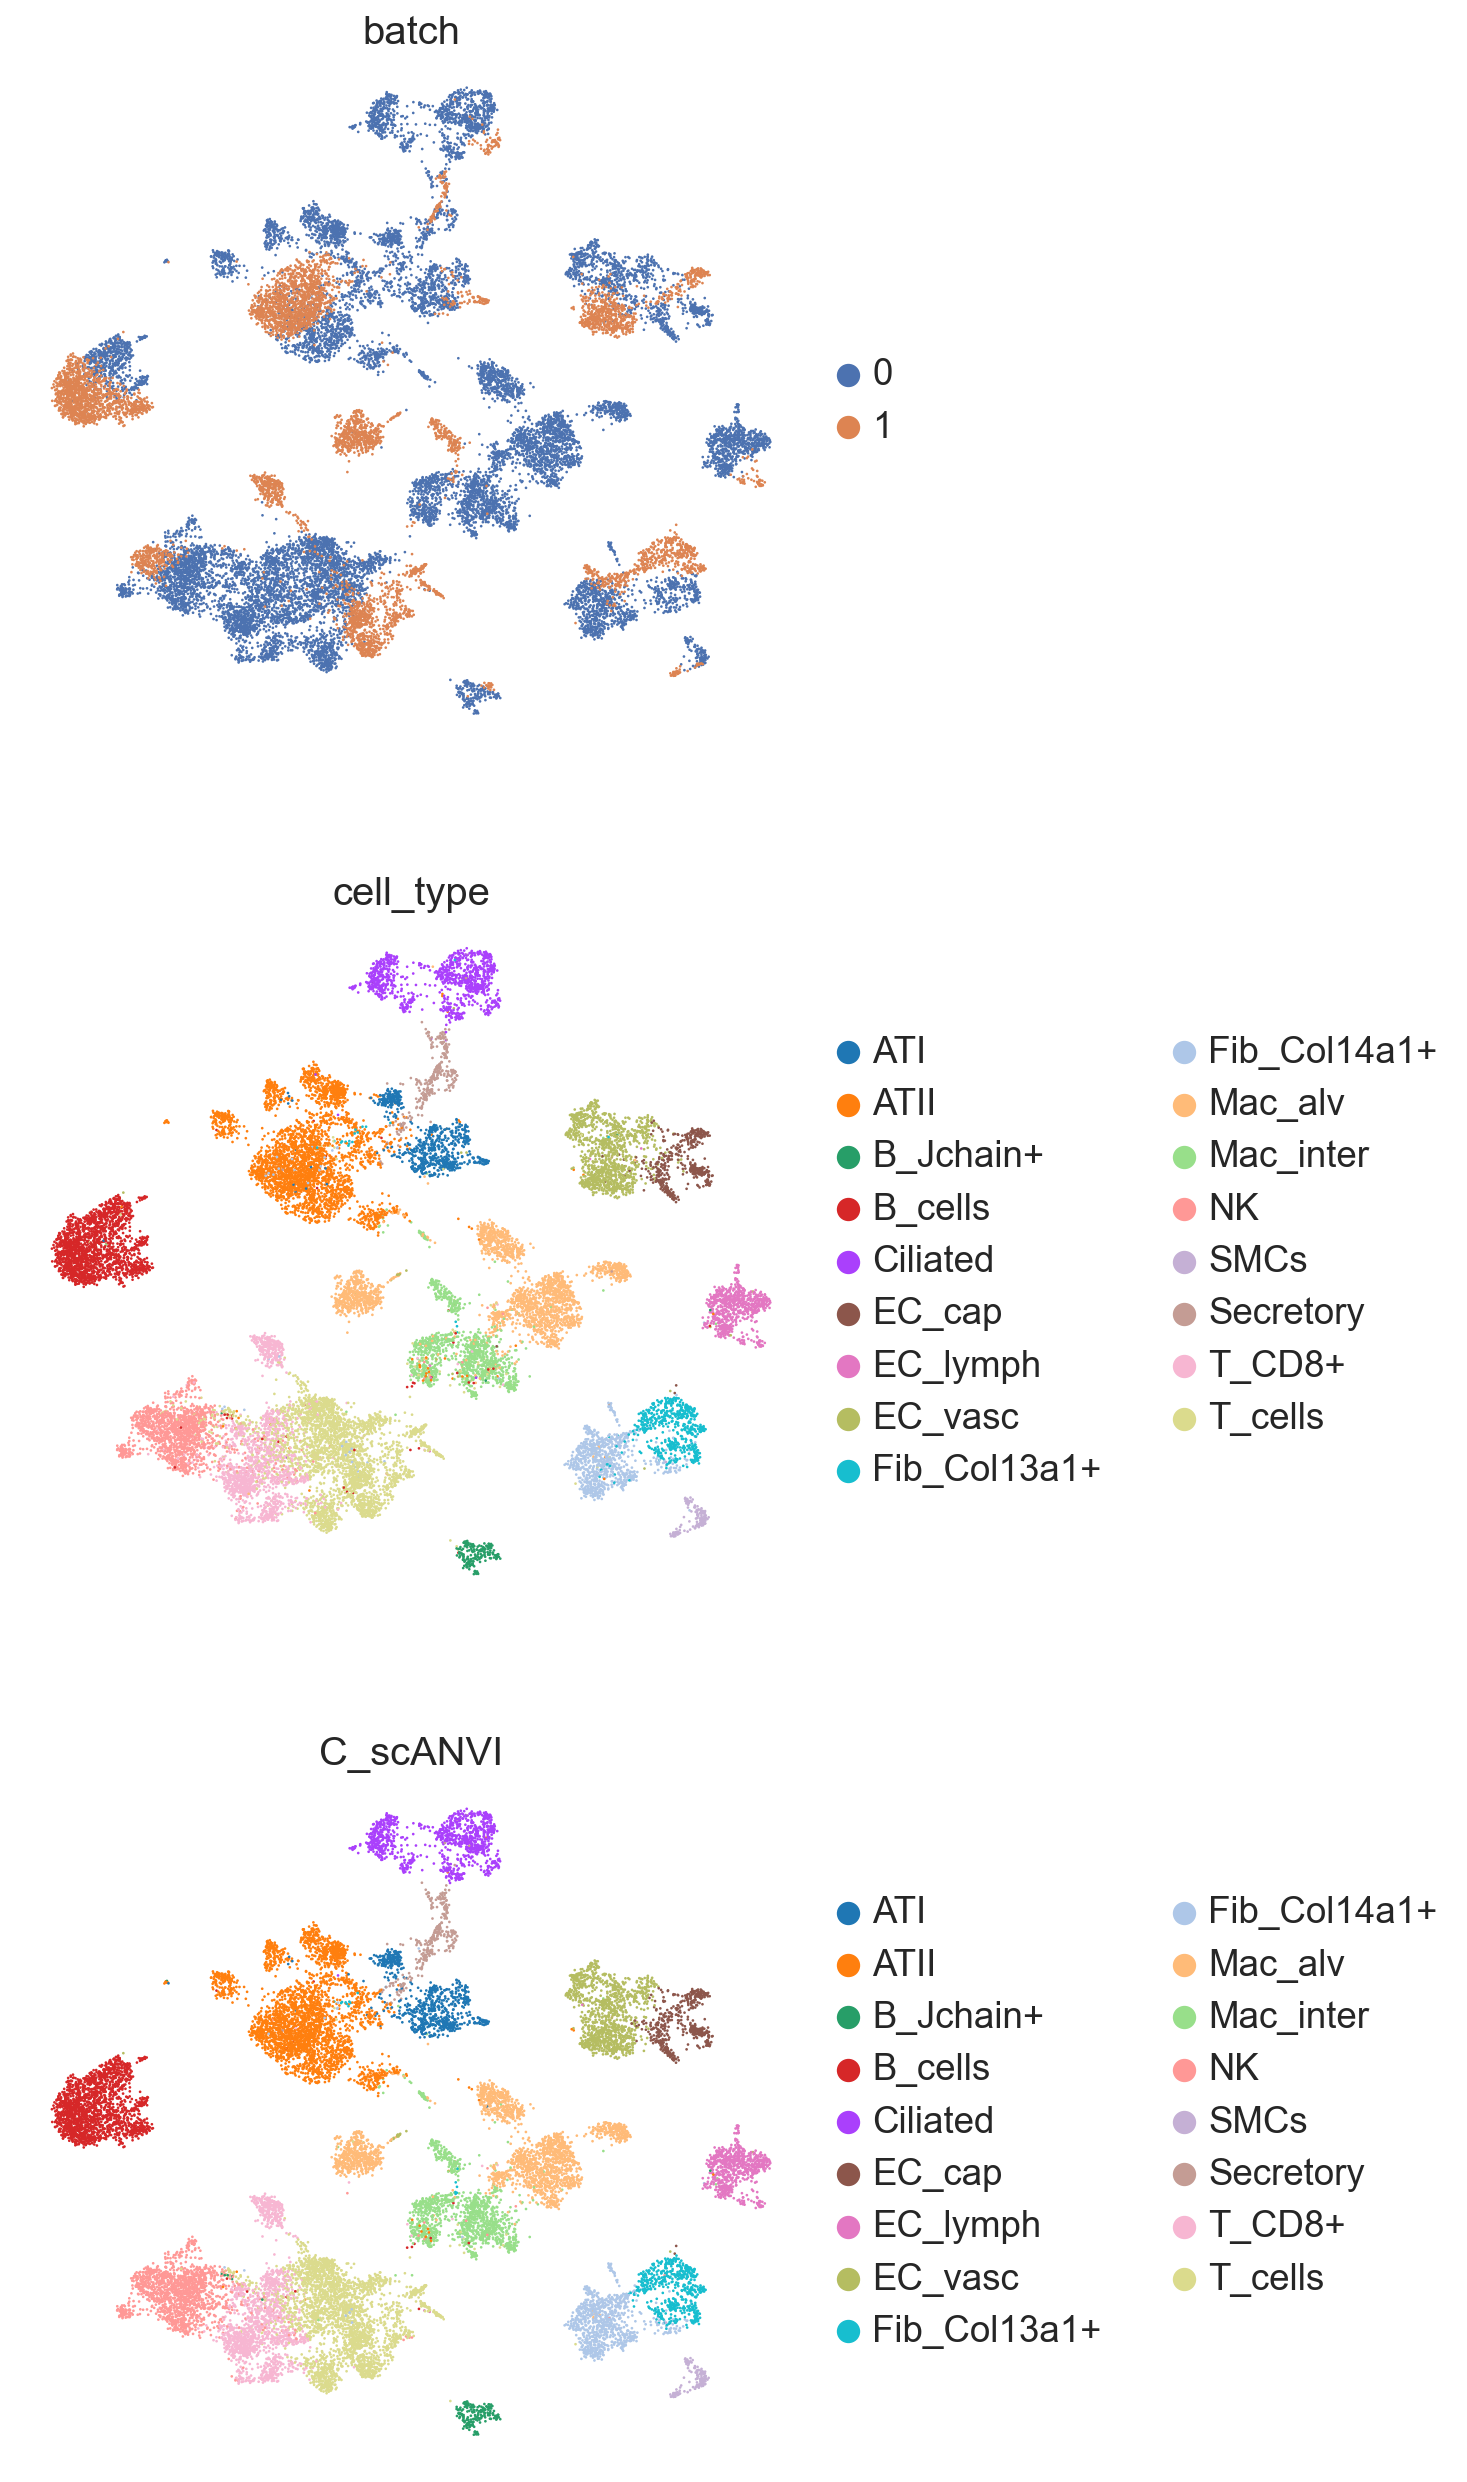

In [25]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [26]:
train = adata.copy()

### Preprocessing Data

In [27]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [28]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|▎| 26/100 [02:53<08:15,  6.69s/it, v_num=1, train_loss_step=7
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 697.532. Signaling Trainer to stop.


## Batch-Removal

In [47]:
corrected_adata = model.batch_removal()
corrected_adata

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 20760 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [30]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [31]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


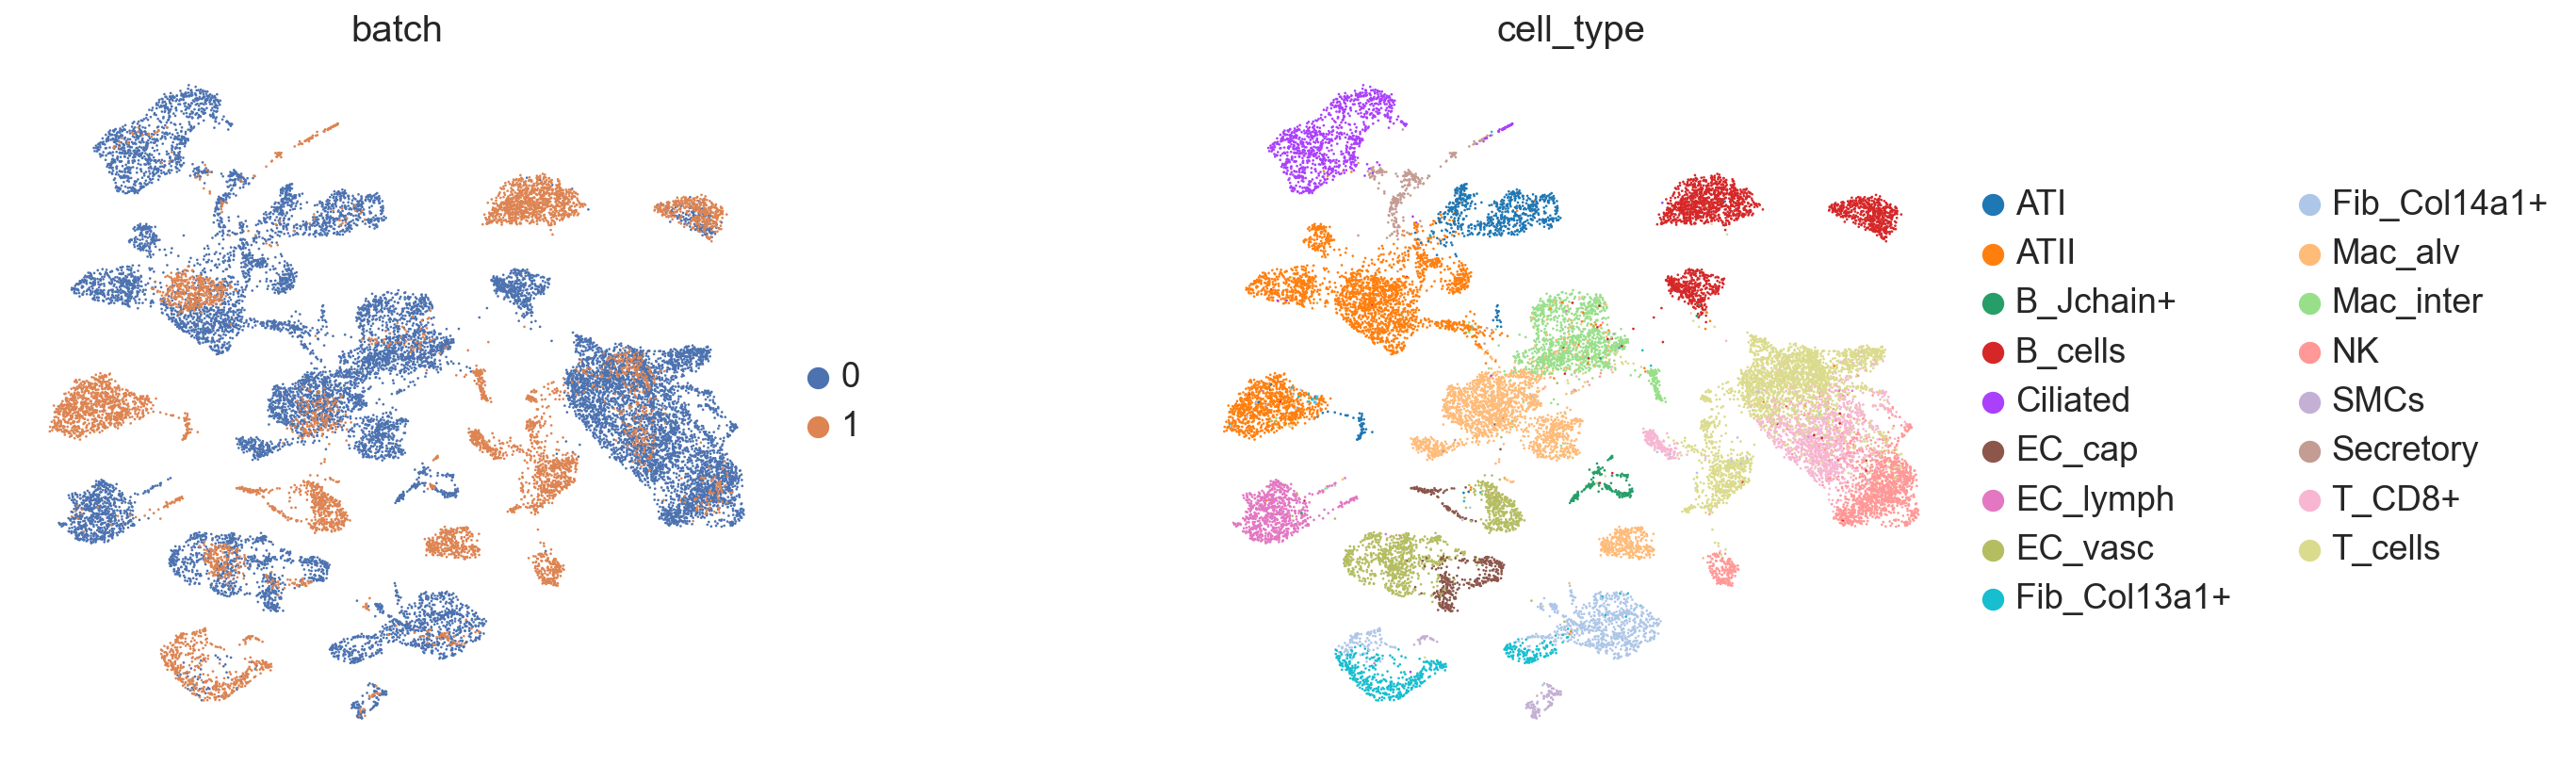

In [32]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [34]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/lung_two_species_stacas_embeddings_randomly_missing_labels_70.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [35]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

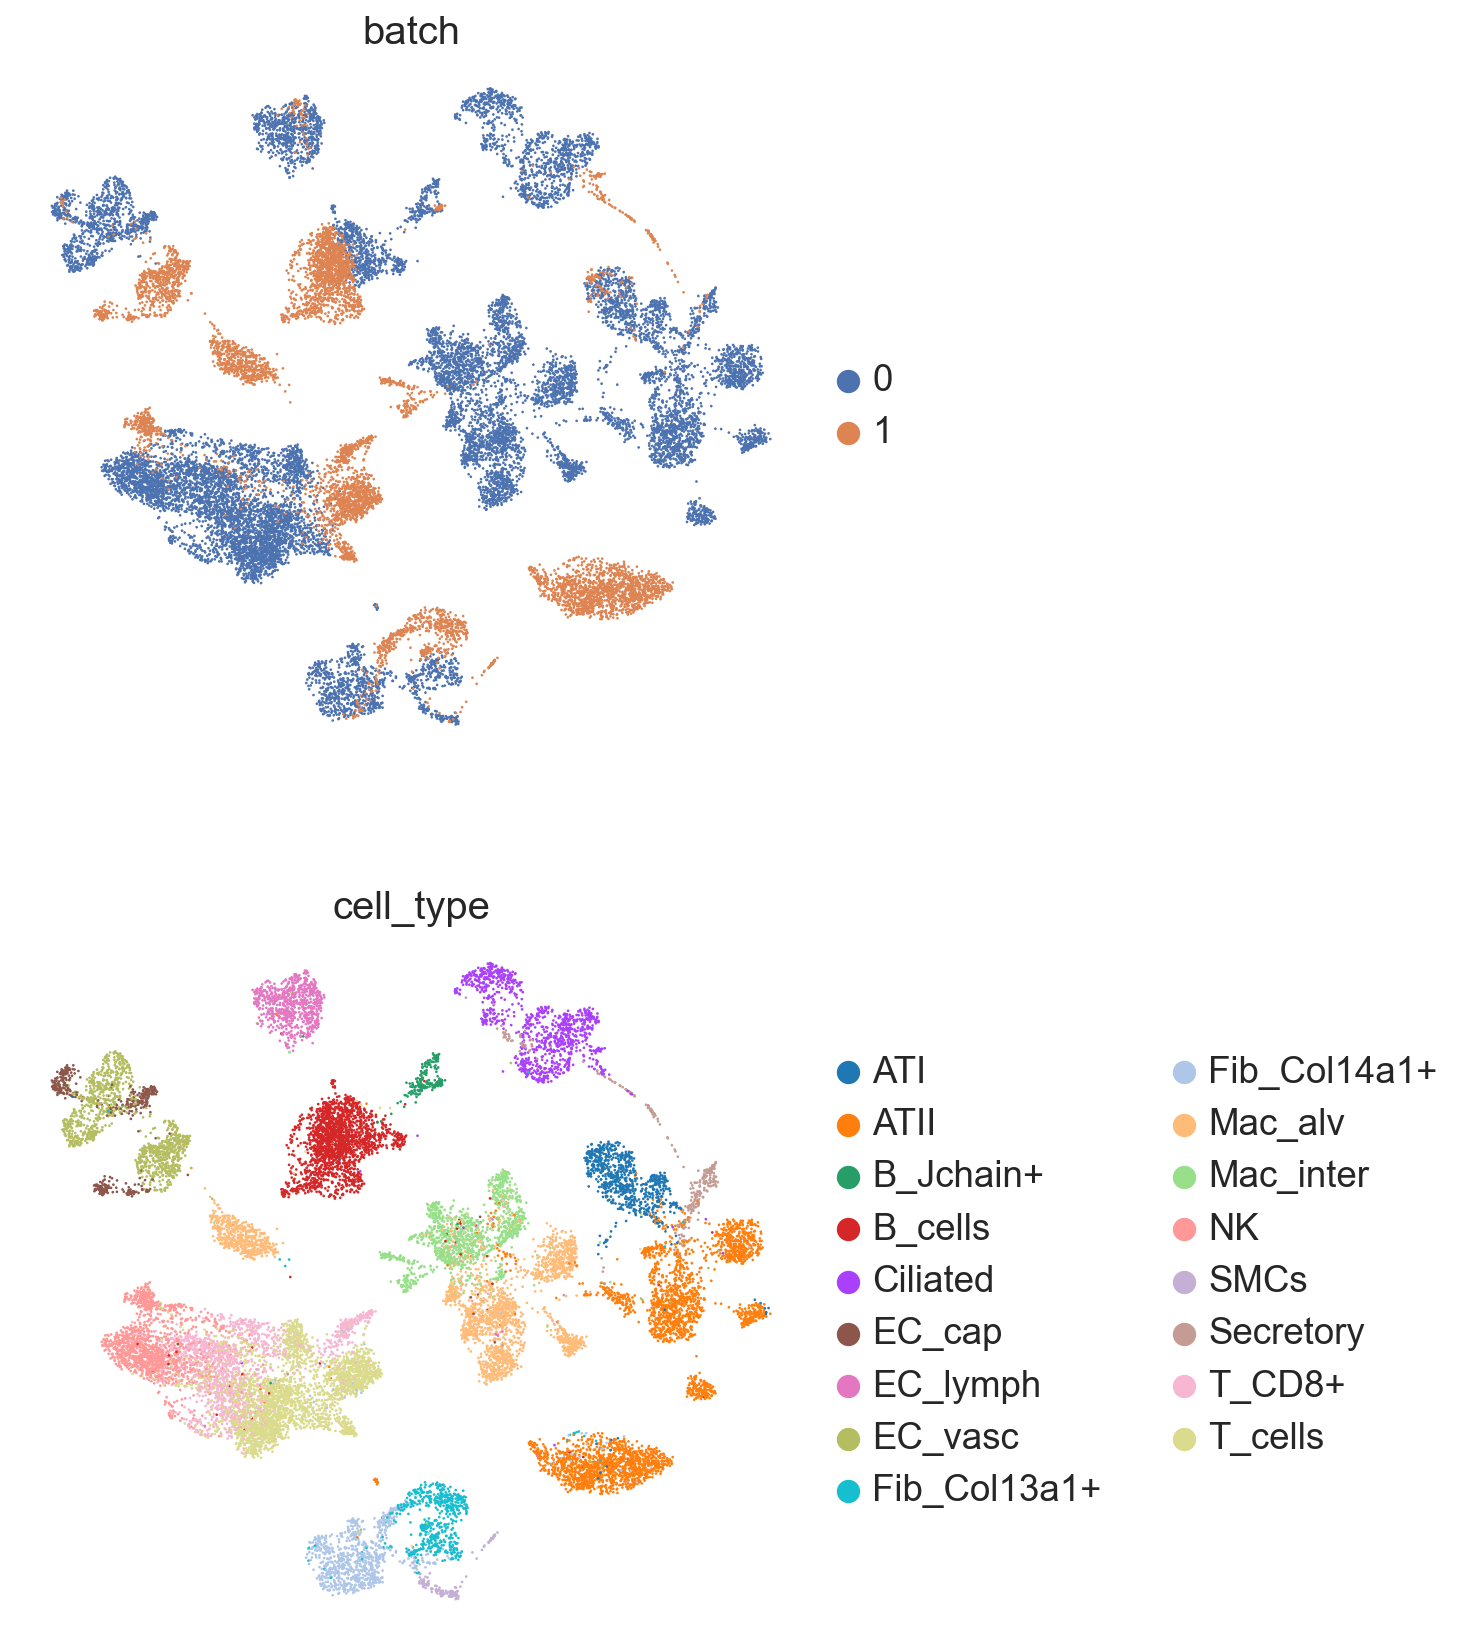

In [36]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [37]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_lung_two_species_70.csv")


# Metric Evaluation

## read the embeddings

In [39]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/randomly_missing_lung_two_species_70.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [40]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,  graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,  isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.8273134109778504
resolution: 0.2, nmi: 0.838551587660012
resolution: 0.3, nmi: 0.8450443812686433
resolution: 0.4, nmi: 0.8250498929316236
resolution: 0.5, nmi: 0.8104787018823978
resolution: 0.6, nmi: 0.8367846063658633
resolution: 0.7, nmi: 0.8151989774381155
resolution: 0.8, nmi: 0.8037685014680721
resolution: 0.9, nmi: 0.8113292231786986
resolution: 1.0, nmi: 0.8047579515638953
resolution: 1.1, nmi: 0.8001320345609385
resolution: 1.2, nmi: 0.7962711856159833
resolution: 1.3, nmi: 0.7978167414811694
resolution: 1.4, nmi: 0.7910303533398125
resolution: 1.5, nmi: 0.774469015484742
resolution: 1.6, nmi: 0.770667303163328
resolution: 1.7, nmi: 0.7656519534000469
resolution: 1.8, nmi: 0.7718333563633992
resolution: 1.9, nmi: 0.7717121100360774
resolution: 2.0, nmi: 0.7664236674322141
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.8450443812686433


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scANVI


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [41]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,  graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,  isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7283907496854064
resolution: 0.2, nmi: 0.747730155716378
resolution: 0.3, nmi: 0.7580171665345529
resolution: 0.4, nmi: 0.7724581665001755
resolution: 0.5, nmi: 0.7759454369673412
resolution: 0.6, nmi: 0.768107261919246
resolution: 0.7, nmi: 0.7673365865576437
resolution: 0.8, nmi: 0.76563612939287
resolution: 0.9, nmi: 0.7638149146621996
resolution: 1.0, nmi: 0.7641279484922109
resolution: 1.1, nmi: 0.7643200575739744
resolution: 1.2, nmi: 0.7566939407267014
resolution: 1.3, nmi: 0.7593930821802787
resolution: 1.4, nmi: 0.7591951453732119
resolution: 1.5, nmi: 0.7553355476736048
resolution: 1.6, nmi: 0.7556957006303324
resolution: 1.7, nmi: 0.7537902502077625
resolution: 1.8, nmi: 0.7488135589997774
resolution: 1.9, nmi: 0.7439431379042725
resolution: 2.0, nmi: 0.7416753397252045
optimised clustering against cell_type
optimal cluster resolution: 0.5
optimal score: 0.7759454369673412


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [42]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True,  graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True,  isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.785990838756894
resolution: 0.2, nmi: 0.7763525059948836
resolution: 0.3, nmi: 0.7816019456264742
resolution: 0.4, nmi: 0.7762537702267673
resolution: 0.5, nmi: 0.7612871818579432
resolution: 0.6, nmi: 0.761535045533956
resolution: 0.7, nmi: 0.762220293928719
resolution: 0.8, nmi: 0.7516807778214625
resolution: 0.9, nmi: 0.7587492206949318
resolution: 1.0, nmi: 0.7562697379247223
resolution: 1.1, nmi: 0.7579504617576045
resolution: 1.2, nmi: 0.7487150958414792
resolution: 1.3, nmi: 0.7457995879315775
resolution: 1.4, nmi: 0.7434606820043078
resolution: 1.5, nmi: 0.7489197191361465
resolution: 1.6, nmi: 0.7406629385941953
resolution: 1.7, nmi: 0.7415223741663276
resolution: 1.8, nmi: 0.7396850438753785
resolution: 1.9, nmi: 0.7404092325813763
resolution: 2.0, nmi: 0.738054211634055
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.785990838756894


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Isolated labels ASW...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_co

In [45]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/lung_two_species_metrics_randomly_missing_70.csv", index=True)

In [46]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.840593,0.770143,0.790830
ARI_cluster/label,0.725178,0.555742,0.591763
ASW_label,0.629744,0.575155,0.616403
ASW_label/batch,0.846467,0.802752,0.785733
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.919982,0.828240,0.832149
isolated_label_silhouette,0.634669,0.575956,0.622090
graph_conn,0.989351,0.959531,0.983333
kBET,NaN,NaN,NaN
